In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings(action="ignore", message=r'.*ntree_limit is deprecated.*')
import sys, pickle
sys.path.append('../../../../')
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from utils.general import calc_true_rank
from utils.feature_ranking import confident_simultaneous_ranking
from utils.feature_importance import get_shap_global
from experiments.simulated_data.low_variance_FI.FI_data_generator import gen_data_fi
%matplotlib inline
sns.set_theme(style='whitegrid')

In [2]:
# Set all fonts' sizes
params = {'legend.fontsize': 32,
          'legend.title_fontsize': 32,
          'axes.labelsize': 36,
          'axes.titlesize':40,
          'xtick.labelsize':32,
          'ytick.labelsize':32, 
          'lines.linewidth': 4}
pylab.rcParams.update(params)

# Avoid Type 3 fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
results_path_shap = r'../../../../results/low_variance_FI/SHAP/'

In [4]:
results_shap = pd.read_csv(results_path_shap + 'feature_importance_ranks_measures_SHAP.csv')
results_shap.head()

,p,n,model_type,func_ind,alpha,rep_bootstrap,rep_seed,rank_method,importance_method,efficiency,coverage,simultaneous_coverage,shap_time,ranking_time
0,50,1000,xgb,2,0.1,2500,61,holm,shap,0.281633,1.0,1,2.935414,1.433925
1,50,1000,xgb,2,0.1,2500,61,min_p,shap,0.275918,1.0,1,2.935414,962.565792
2,50,1000,xgb,2,0.1,2500,61,icranks,shap,0.271020,1.0,1,2.935414,2.513952
3,50,1000,xgb,2,0.1,2500,71,holm,shap,0.257143,1.0,1,3.187625,1.523734
4,50,1000,xgb,2,0.1,2500,71,min_p,shap,0.260408,1.0,1,3.187625,962.474596


In [5]:
no_cover = results_shap[results_shap['func_ind'] == 3].reset_index(drop=True)

In [6]:
no_cover = no_cover.drop(['alpha', 'rep_bootstrap', 'rep_seed', 'importance_method'], axis=1)
no_cover['rank_method'] = no_cover['rank_method'].map({'holm': 'Holm', 'min_p': 'Min-P', 'icranks': 'ICRanks'})
no_cover = no_cover.rename(columns={'rank_method': 'Ranking Method'})

In [7]:
no_cover.head()

,p,n,model_type,func_ind,Ranking Method,efficiency,coverage,simultaneous_coverage,shap_time,ranking_time
0,50,1000,xgb,3,Holm,0.120816,0.58,0,3.695300,1.588448
1,50,1000,xgb,3,Min-P,0.212245,0.68,0,3.695300,997.267268
2,50,1000,xgb,3,ICRanks,0.120000,0.58,0,3.695300,1.065064
3,50,1000,xgb,3,Holm,0.089796,0.38,0,2.663882,1.504313
4,50,1000,xgb,3,Min-P,0.108571,0.42,0,2.663882,863.202113


In [8]:
no_cover_plot = no_cover[((no_cover['p'] == 30) & (no_cover['model_type'] == 'rf'))].reset_index(drop=True)

In [9]:
no_cover_summary = no_cover_plot.groupby(['n', 'model_type', 'Ranking Method'])
no_cover_summary = no_cover_summary.agg(efficiency_mean=('efficiency', 'mean'), 
                        efficiency_std=('efficiency', 'std'), 
                        coverage_mean=('coverage', 'mean'), 
                        coverage_std=('coverage', 'std'), 
                        simultaneous_coverage_mean=('simultaneous_coverage', 'mean'), 
                        simultaneous_coverage_std=('simultaneous_coverage', 'std'))
no_cover_summary = no_cover_summary.reset_index()

In [10]:
no_cover_summary[no_cover_summary['simultaneous_coverage_mean'] >= 0.9]

,n,model_type,Ranking Method,efficiency_mean,efficiency_std,coverage_mean,coverage_std,simultaneous_coverage_mean,simultaneous_coverage_std
2,100,rf,Min-P,0.74269,0.266516,0.996333,0.01413,0.92,0.27266


In [11]:
no_cover_summary.round(3)

,n,model_type,Ranking Method,efficiency_mean,efficiency_std,coverage_mean,coverage_std,simultaneous_coverage_mean,simultaneous_coverage_std
0,100,rf,Holm,0.192,0.122,0.904,0.084,0.19,0.394
1,100,rf,ICRanks,0.175,0.111,0.889,0.092,0.15,0.359
2,100,rf,Min-P,0.743,0.267,0.996,0.014,0.92,0.273
3,500,rf,Holm,0.142,0.105,0.826,0.124,0.08,0.273
4,500,rf,ICRanks,0.137,0.105,0.818,0.126,0.07,0.256
5,500,rf,Min-P,0.537,0.349,0.954,0.089,0.65,0.479
6,1000,rf,Holm,0.126,0.098,0.795,0.135,0.09,0.288
7,1000,rf,ICRanks,0.122,0.096,0.790,0.141,0.10,0.302
8,1000,rf,Min-P,0.473,0.356,0.925,0.112,0.55,0.500
9,3000,rf,Holm,0.086,0.067,0.723,0.161,0.05,0.219


In [12]:
n = 1000
p = 30
func_ind = 3
rep_seed = 1
alpha = 0.1
method = 'min_p'
model_type = 'rf'
rep_bootstrap = 2500

model_params = {'model_type': model_type, 'func_ind': func_ind, 'p': p}
model_config_path = results_path_shap + 'models/'
model_params_str = '_'.join([str(val) for val in model_params.values()])
model_config_filename = model_config_path + model_params_str + '.sav'
model_config = pickle.load(open(model_config_filename, 'rb'))

In [13]:
explainer = model_config['explainer']

In [14]:
true_filename = results_path_shap + '/true_feature_importance_all_models.npy'
true_importance = np.load(true_filename, allow_pickle=True).item()
shap_true = true_importance[model_params_str]['shap_means_true']
true_rank_L, true_rank_U = calc_true_rank(shap_true)

In [15]:
rep = 10
all_ranks = []
for i in range(rep):
    data, target_name = gen_data_fi(n, p, func_ind, seed=i+1)
    feature_names = data.columns.drop(target_name)
    shap_means, _, shap_values = get_shap_global(explainer, data[feature_names], return_local=True)
    base_values = np.abs(shap_values)
    shap_set_ranks = confident_simultaneous_ranking(base_values, alpha, method=method, rep_bootstrap=rep_bootstrap)
    shap_set_ranks.insert(0, 'feature', feature_names)
    shap_set_ranks['True_L'] = true_rank_L
    shap_set_ranks['True_U'] = true_rank_U
    shap_set_ranks['coverage'] = ((shap_set_ranks['L'] <= shap_set_ranks['True_L']) & (shap_set_ranks['True_U'] <= shap_set_ranks['U']))
    shap_set_ranks['seed'] = i + 1
    all_ranks.append(shap_set_ranks)


all_ranks = pd.concat(all_ranks).reset_index(drop=True)
all_ranks.head()

,feature,L,U,True_L,True_U,coverage,seed
0,X1,18,19,19,19,True,1
1,X2,22,24,23,23,True,1
2,X3,27,28,27,27,True,1
3,X4,7,11,9,9,True,1
4,X5,10,12,7,7,False,1


In [16]:
all_ranks.groupby('feature')['coverage'].mean().sort_values().head(10)

feature
X9     0.3
X19    0.3
X15    0.5
X25    0.5
X5     0.5
X7     0.6
X27    0.6
X8     0.7
X30    0.8
X24    0.8
Name: coverage, dtype: float64

In [17]:
n = 1000
seed = 1
data, target_name = gen_data_fi(n, p, func_ind, seed=seed)
feature_names = data.columns.drop(target_name)
shap_means, _, shap_values = get_shap_global(explainer, data[feature_names], return_local=True)
base_values = np.abs(shap_values)
base_values = pd.DataFrame(base_values, columns=feature_names)

In [18]:
base_values_selected = base_values[['X16', 'X23']]

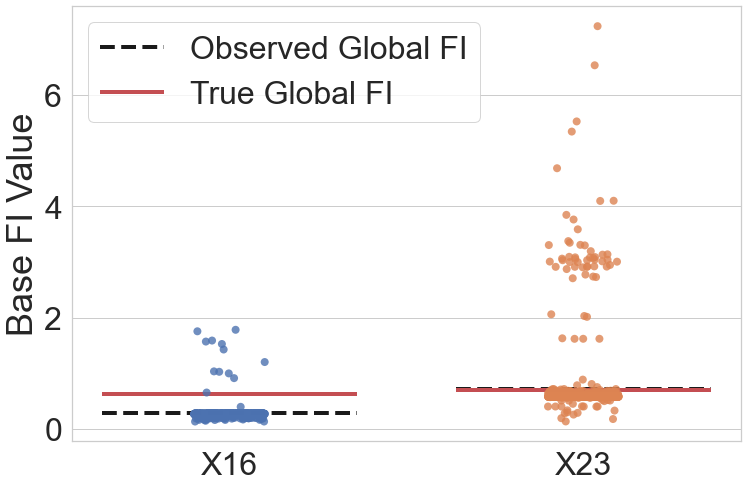

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
base_importance_long = base_values_selected.stack().reset_index().drop('level_0', axis=1)
base_importance_long.columns = ['Feature', 'Importance']
spec = dict(x='Feature', y='Importance', data=base_importance_long)
sns.stripplot(**spec, size=8, alpha=0.8, ax=ax)
ax.hlines(y=shap_means[[15, 22]], xmin=[-0.36, 0.64], xmax=[0.36, 1.36], 
          linewidths=4, colors='k', linestyles='--', label='Observed Global FI')
ax.hlines(y=shap_true[[15, 22]], xmin=[-0.36, 0.64], xmax=[0.36, 1.36], 
          linewidths=4, colors='r', label='True Global FI')
ax.set_xlabel(None)
ax.set_ylabel('Base FI Value')
ax.legend();